In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [2]:
datapath = Path.cwd() / "AL"
datapath2 = Path.cwd().parent / "ED/data/"
figurepath = Path.cwd().parent / "figures/MBL"

In [3]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [4]:
def set_size(width='thesis', fraction=1, subplots=(1, 1),aspect_ratio=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


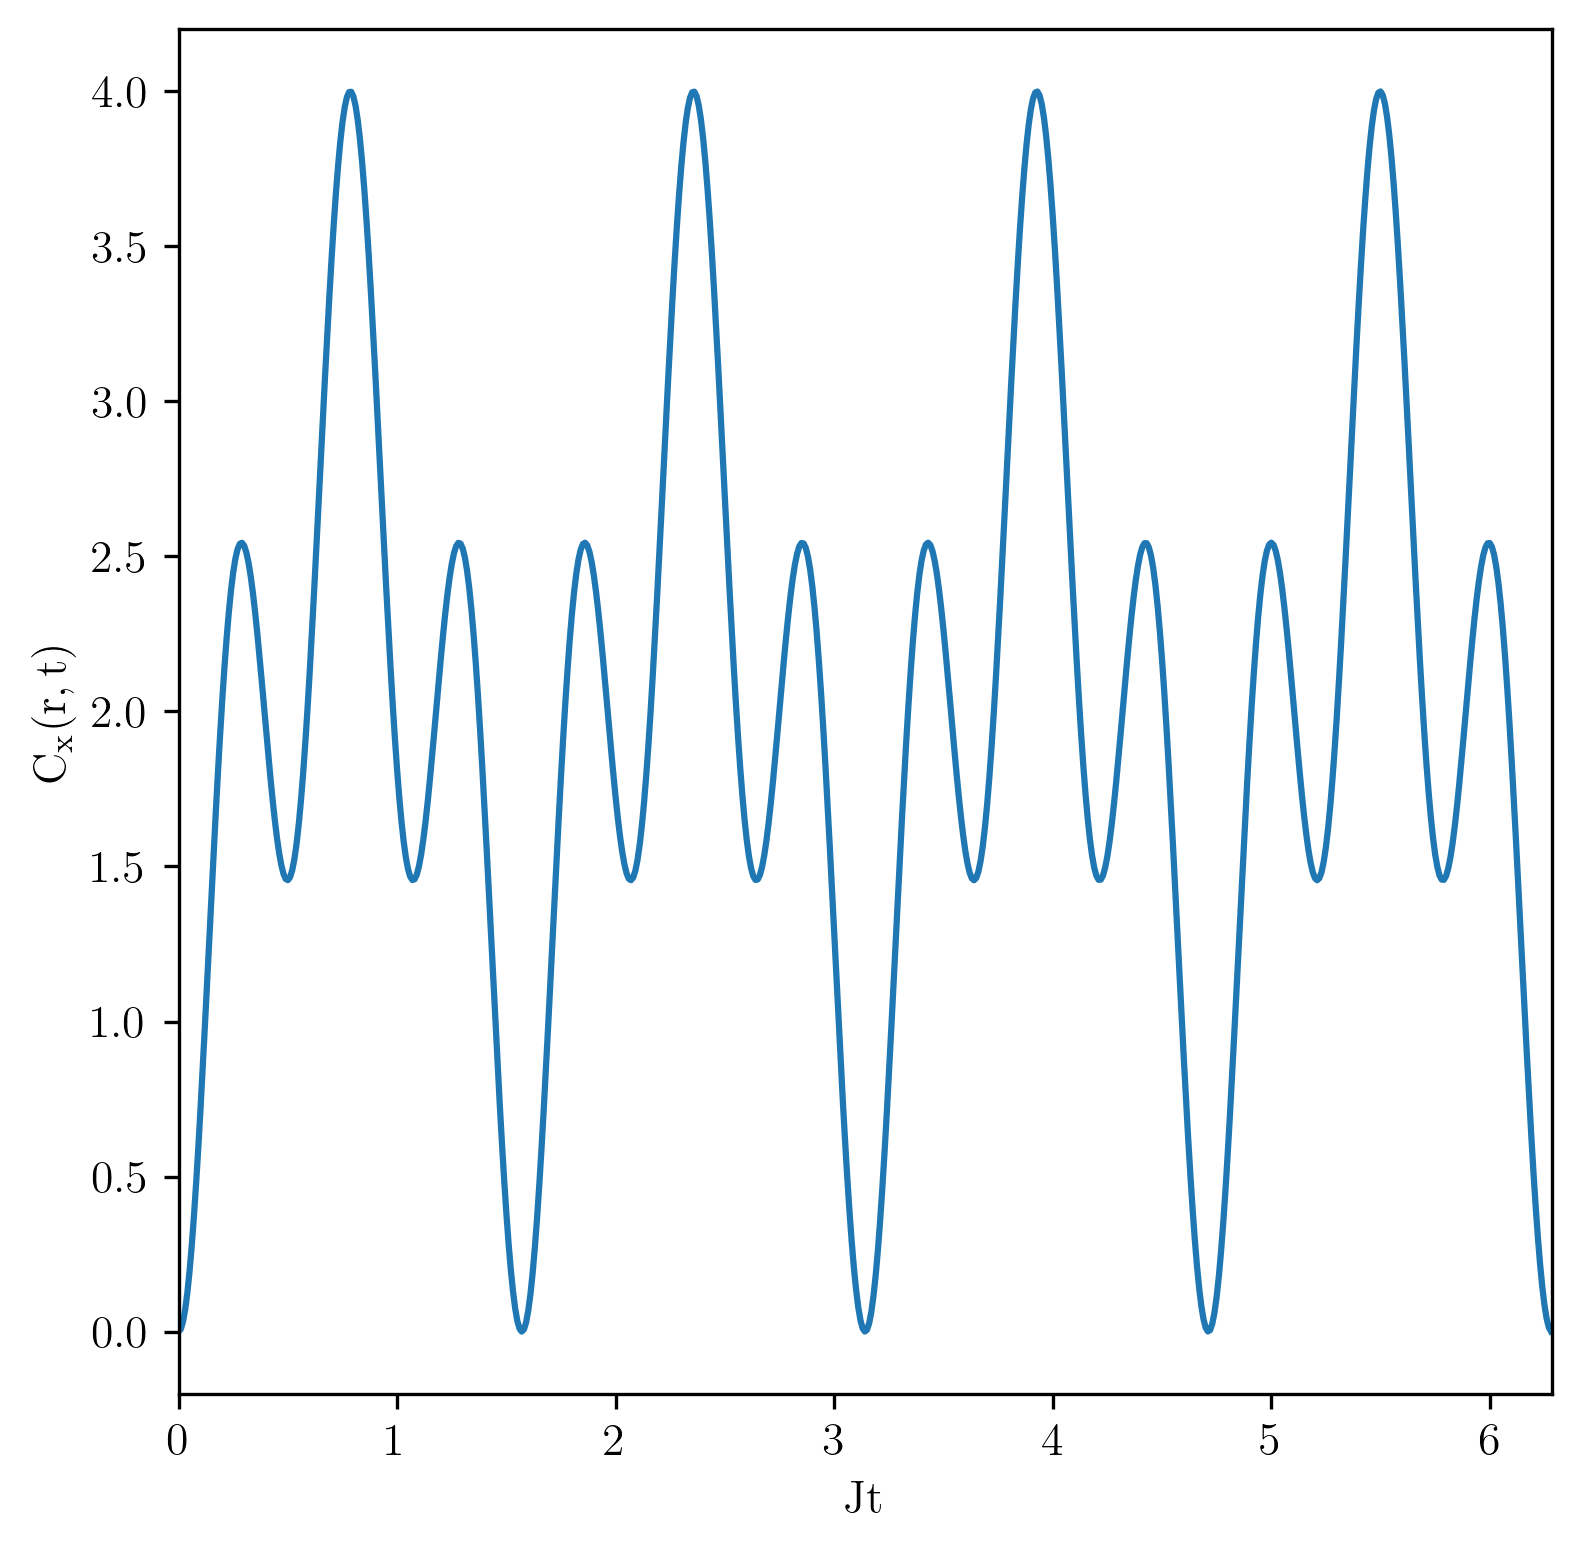

In [5]:
def f(t):
    return 2*(np.sin(2*t)**2+np.sin(6*t)**2)
T = np.arange(0,np.pi*2,0.01)
fig = plt.figure(figsize=set_size(),dpi=300)
plt.plot(T,f(T))
plt.ylabel(r"$\mathrm{C_x(r,t)}$")
plt.xlabel("Jt")
plt.xlim(0,np.pi*2)

#plt.savefig(figurepath/"PairOTOC.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

In [6]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [7]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [8]:
jobids = []
params = []
data = []
data_nn = []
folders = [datapath/"pl",datapath2/"xx/h = 24 ext",datapath2/"OBC_offcenter/xx_h24"]
files = ["combined_file_pl.jld2","combined_file_h24.jld2","combined_file_xx.jld2"] 
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])
folders_nn = [datapath/"nn",datapath2/"xx_nn/h = 24 ext",datapath2/"OBC_offcenter/xx_nn_h24"]
files_nn = ["combined_file_nn.jld2","combined_file_h24.jld2","combined_file_xxnn.jld2"]
for (i,file) in enumerate(files_nn):
    with h5py.File(folders_nn[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
    data_nn[i] = np.concatenate(data_nn[i],axis=0)
    data_nn[i] = rearrange_data(data_nn[i])

/tmp/ipykernel_86009/2401001407.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
/tmp/ipykernel_86009/2401001407.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))


In [9]:
N = 13
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [10]:
res = [disorder_mean(data[i]) for i in range(len(files))]
res_sem = [disorder_sem(data[i]) for i in range(len(files))]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

res_nn = [disorder_mean(data_nn[i]) for i in range(len(files_nn))]
res_sem_nn = [disorder_sem(data_nn[i]) for i in range(len(files_nn))]
red_nn = list(map(symmetrize,res_nn))
red_sem_nn = list(map(symmetrize,res_sem_nn))

In [11]:
for i in range(len(files)):
    print(data[i].shape[2],"  nn ",data_nn[i].shape[2],"\n")

500   nn  500 

6000   nn  6000 

500   nn  500 



# Light Cone Plot

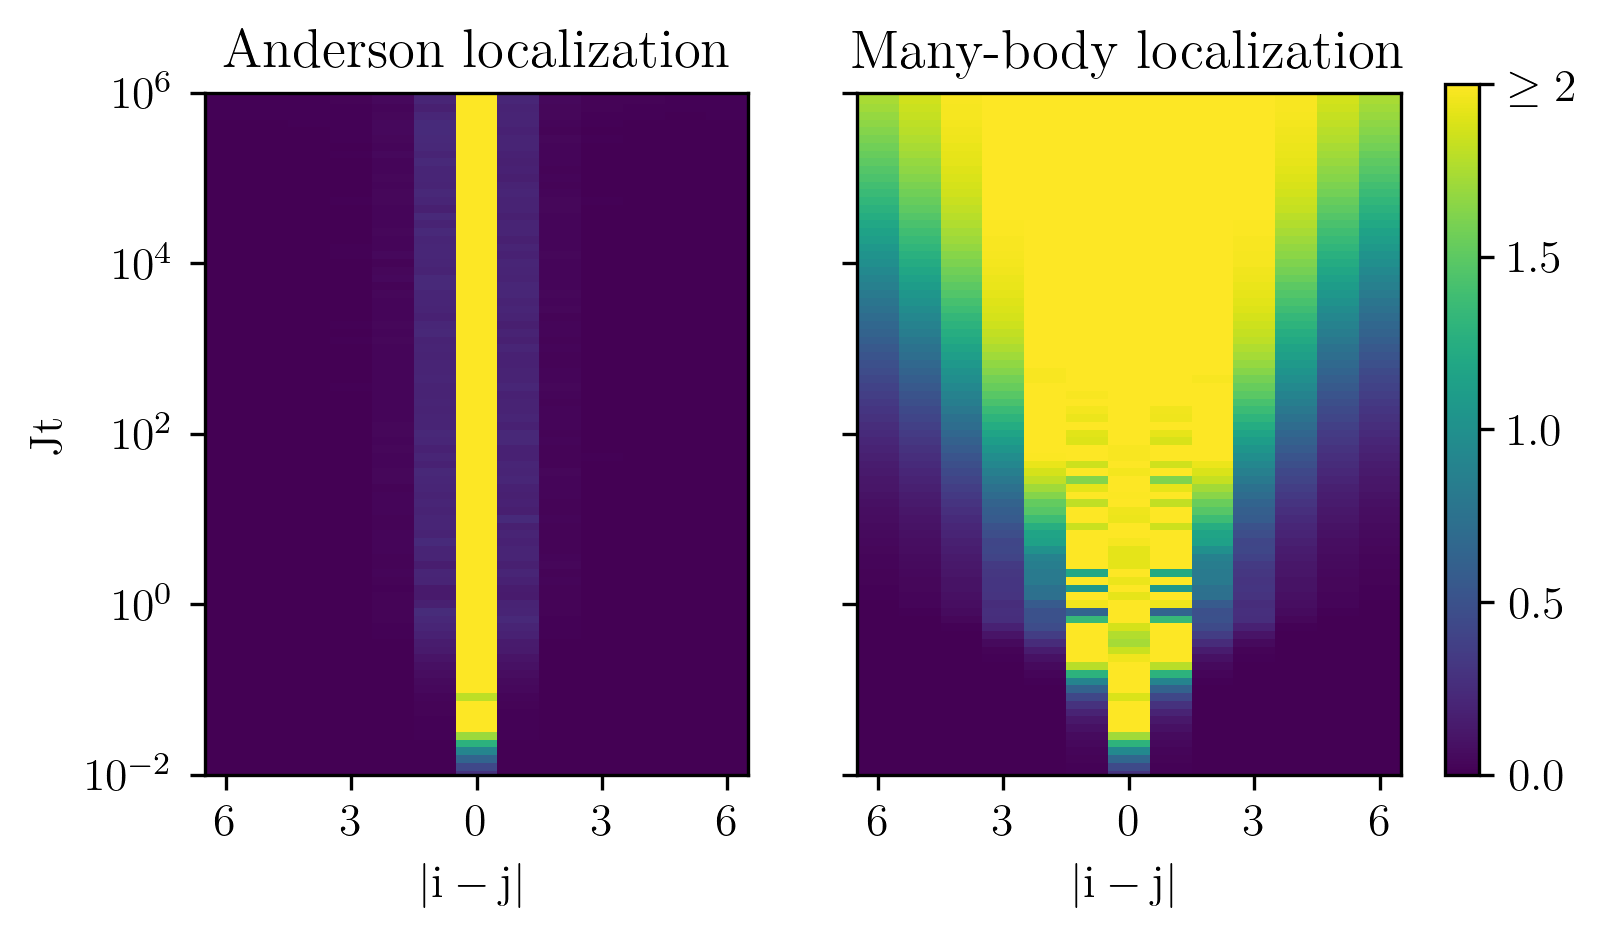

In [12]:
res_safe_AL = np.clip(res_nn[0],1e-14,2)
res_safe_MBL = np.clip(res_nn[1],1e-14,2)
thresholds = [0.1,0.33,0.66,1,1.5,2]

fit_params = []
fit_errs = []
tvals = []
masks = []
# for (i,th) in enumerate(thresholds):
#     tvals.append(T_transgression(T,res_safe,th))
#     masks.append(np.isfinite(tvals[i])) 
#     popt, pcov = curve_fit(model,rvals[masks[i]],tvals[i][masks[i]])
#     fit_params.append(popt)
#     fit_errs.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)

pcm = axs[0].pcolormesh(range(0,N),T,res_safe_AL,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
# for (i,th) in enumerate(thresholds):
#     #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
#     ax1.plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
#     ax1.plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
#     ax1.scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 2)
# ax1.scatter(np.arange(0,8,1),tcut_zz,marker="o",color="red",s=2)
# ax1.scatter(np.arange(8+3,N,1),np.flip(tcut_zz),marker="o",color="red",s=2)
axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,3,N//2,9,N-1])
axs[0].set_xticklabels([6,3,0,3,6])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("Anderson localization")



pcm2 = axs[1].pcolormesh(range(0,N),T,res_safe_MBL,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title("Many-body localization")


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])

#plt.savefig(figurepath/"ALvsMBL_nn.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

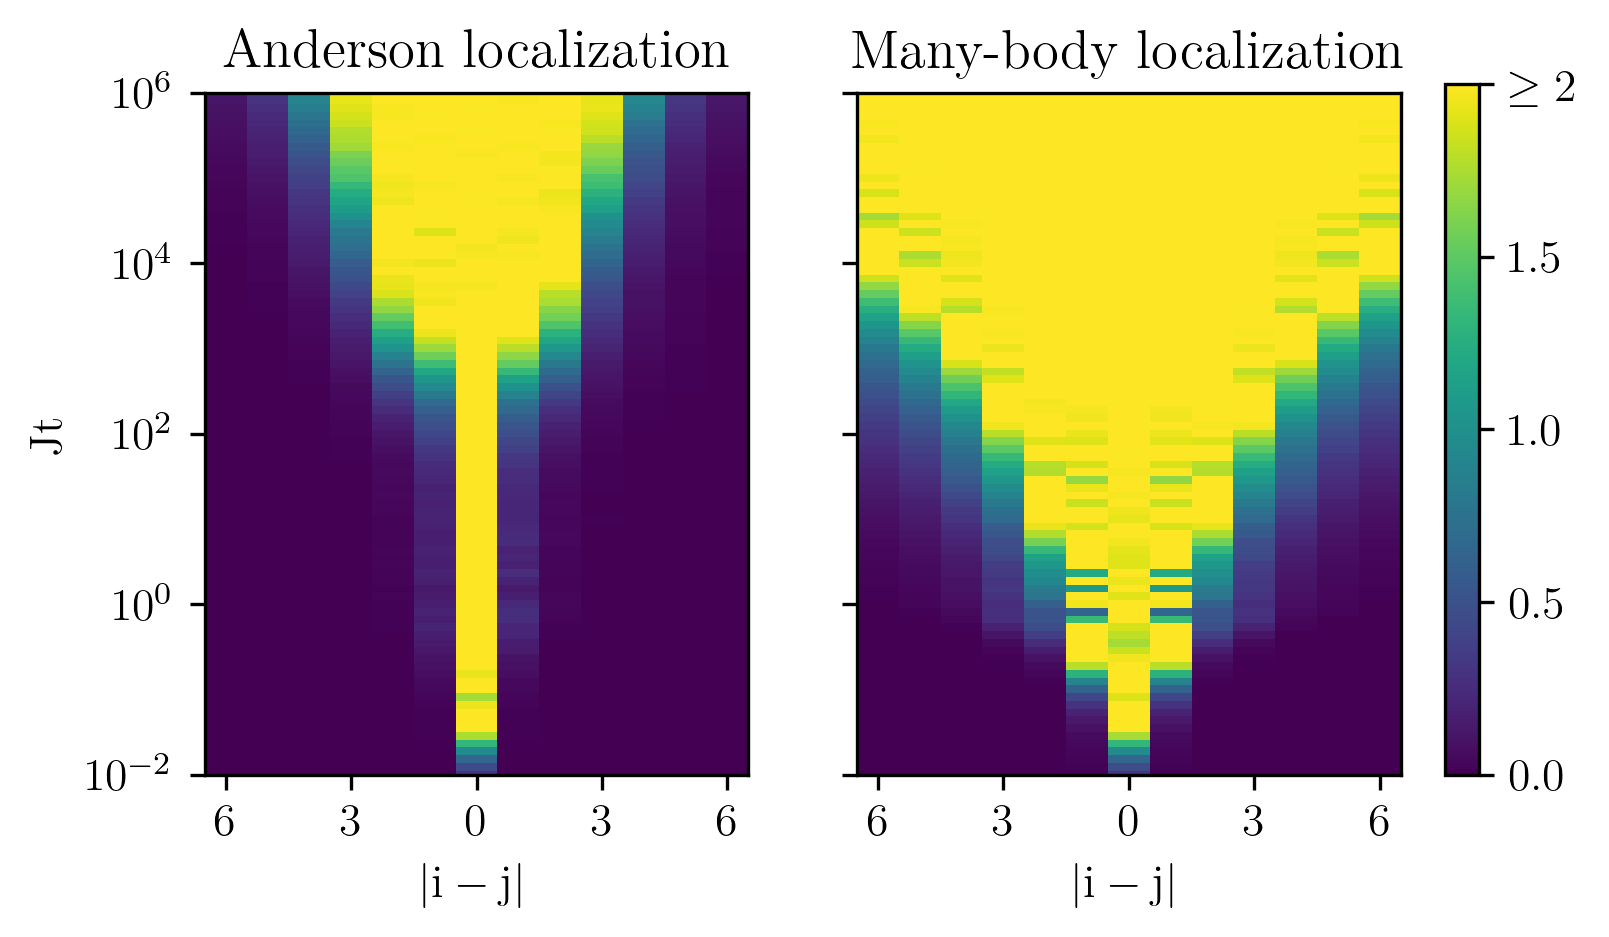

In [13]:
res_safe_AL = np.clip(res[0],1e-14,2)
res_safe_MBL = np.clip(res[1],1e-14,2)
thresholds = [0.1,0.33,0.66,1,1.5,2]

fit_params = []
fit_errs = []
tvals = []
masks = []
# for (i,th) in enumerate(thresholds):
#     tvals.append(T_transgression(T,res_safe,th))
#     masks.append(np.isfinite(tvals[i])) 
#     popt, pcov = curve_fit(model,rvals[masks[i]],tvals[i][masks[i]])
#     fit_params.append(popt)
#     fit_errs.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)

pcm = axs[0].pcolormesh(range(0,N),T,res_safe_AL,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
# for (i,th) in enumerate(thresholds):
#     #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
#     ax1.plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
#     ax1.plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
#     ax1.scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 2)
# ax1.scatter(np.arange(0,8,1),tcut_zz,marker="o",color="red",s=2)
# ax1.scatter(np.arange(8+3,N,1),np.flip(tcut_zz),marker="o",color="red",s=2)
axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,3,N//2,9,N-1])
axs[0].set_xticklabels([6,3,0,3,6])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("Anderson localization")




pcm2 = axs[1].pcolormesh(range(0,N),T,res_safe_MBL,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title("Many-body localization")



plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])

#plt.savefig(figurepath/"ALvsMBL_pl.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Scalings

In [14]:
def model1(x,a,b):
    return a*x+b
def model2(x,a,b,c):
    return a*x**b+c
def model3(x,a,b):
    return a*np.log(x)+b
def model4(x,a,b,c):
    return a*np.log(x)**b+c

In [15]:
np.mean(ts,axis=1)[2]

NameError: name 'ts' is not defined

In [ ]:
np.std(ts,axis=1)[0,:]/np.sqrt(500)

array([4.29702502e+03, 1.06757458e+03, 1.49498283e+02, 8.38266496e+00,
       7.00793423e-01, 1.01873602e-04, 6.71991399e-04, 1.02726956e-04,
       6.80168611e-01, 8.25231864e+00, 1.86721190e+02, 9.29936332e+02,
       3.47214906e+03])

In [16]:
tvals[2]

IndexError: list index out of range

[6 5 4 3 2 2 3 4 5 6]
[6 5 4 3 2 2 3 4 5 6]
[6 5 4 3 2 2 3 4 5 6]
[array([ 2.70907819, -2.00771463]), array([ 3.14083457, -1.60779361]), array([ 3.77081107, -1.52899105])] [array([ 2.4603456 , -1.94512602]), array([ 2.61421396, -1.4494744 ]), array([ 2.67511554, -1.13085077])]


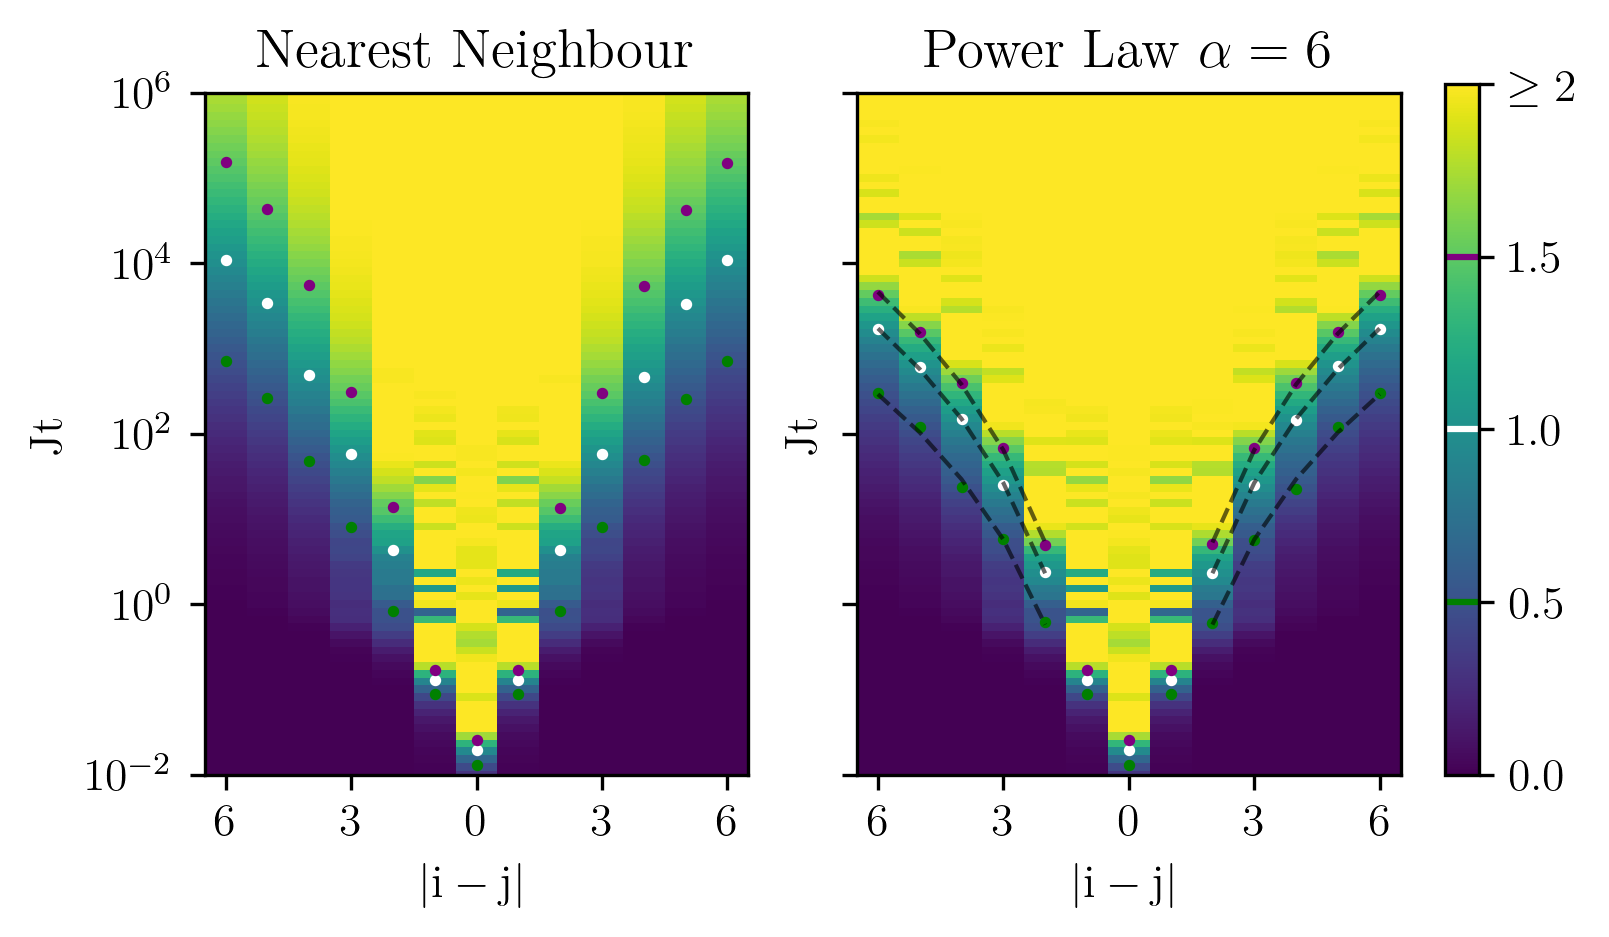

In [17]:
res_safe_MBL_pl = np.clip(res[1],1e-14,2)
res_safe_MBL = np.clip(res_nn[1],1e-14,2)
thresholds = [0.5,1.0,1.5]

fit_params = []
fit_errs = []
tvals = []
masks = []
fit_params_pl = []
fit_errs_pl = []
tvals_pl = []
masks_pl = []

ts = np.zeros((3,6000,13))
ts_pl = np.zeros((3,6000,13))

for (i,th) in enumerate(thresholds):
    for s in range(6000):
        ts[i,s,:]=T_transgression(T,data_nn[1][:,:,s],th)
    #tvals.append(np.mean(ts,axis=1))
    tvals.append(T_transgression(T,res_safe_MBL,th))
    masks.append(np.isfinite(tvals[i]))
    masks[i][N//2-1:N//2+2] = False
    print(rvals[masks[i]])
    popt, pcov = curve_fit(model3,rvals[masks[i]],np.log10(tvals[i][masks[i]]))
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))



    for s in range(6000):
        ts_pl[i,s,:]=T_transgression(T,data[1][:,:,s],th)
    #tvals_pl.append(np.mean(ts_pl,axis=1))
    tvals_pl.append(T_transgression(T,res_safe_MBL_pl,th))
    masks_pl.append(np.isfinite(tvals_pl[i]))
    masks_pl[i][N//2-1:N//2+2] = False
    popt, pcov = curve_fit(model3,rvals[masks_pl[i]],np.log10(tvals_pl[i][masks_pl[i]]))
    fit_params_pl.append(popt)
    fit_errs_pl.append(np.sqrt(np.diag(pcov)))

print(fit_params,fit_params_pl)

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)


pcm = axs[0].pcolormesh(range(0,N),T,res_safe_MBL,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    #axs[0].plot(np.arange(0,N,1)[0:N//2-1],10**model3(rvals[0:N//2-1],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[0].plot(np.arange(0,N,1)[N//2+2:],10**model3(rvals[N//2+2:],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[0].plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[0].plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[0].scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 3)

axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,3,N//2,9,N-1])
axs[0].set_xticklabels([6,3,0,3,6])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("Nearest Neighbour")


pcm2 = axs[1].pcolormesh(range(0,N),T,res_safe_MBL_pl,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[1].plot(np.arange(0,N,1)[:N//2-1],10**model3(rvals[0:N//2-1],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[1].plot(np.arange(0,N,1)[N//2+2:],10**model3(rvals[N//2+2:],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[1].plot(np.arange(0,N//2,1),tvals_pl[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[1].plot(np.arange(N//2+1,N,1),tvals_pl[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[1].scatter(np.arange(0,N,1),tvals_pl[i], marker= "o", c = mcolors2[i], s = 3)

axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title(r"Power Law $\alpha=6$")
axs[1].set_ylabel("Jt")


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])

#plt.savefig(figurepath/"MBL_plvsMBL_nn.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

In [18]:
np.sum((10**model1(rvals[0:N//2-1],*fit_params[0])-tvals[0][0:N//2-1])**2)

3.115377310243984e+28

In [19]:
np.sum((10**model3(rvals[0:N//2-1],*fit_params[0])-tvals[0][0:N//2-1])**2)

1702.7864795637352

# Anderson vs Anderson

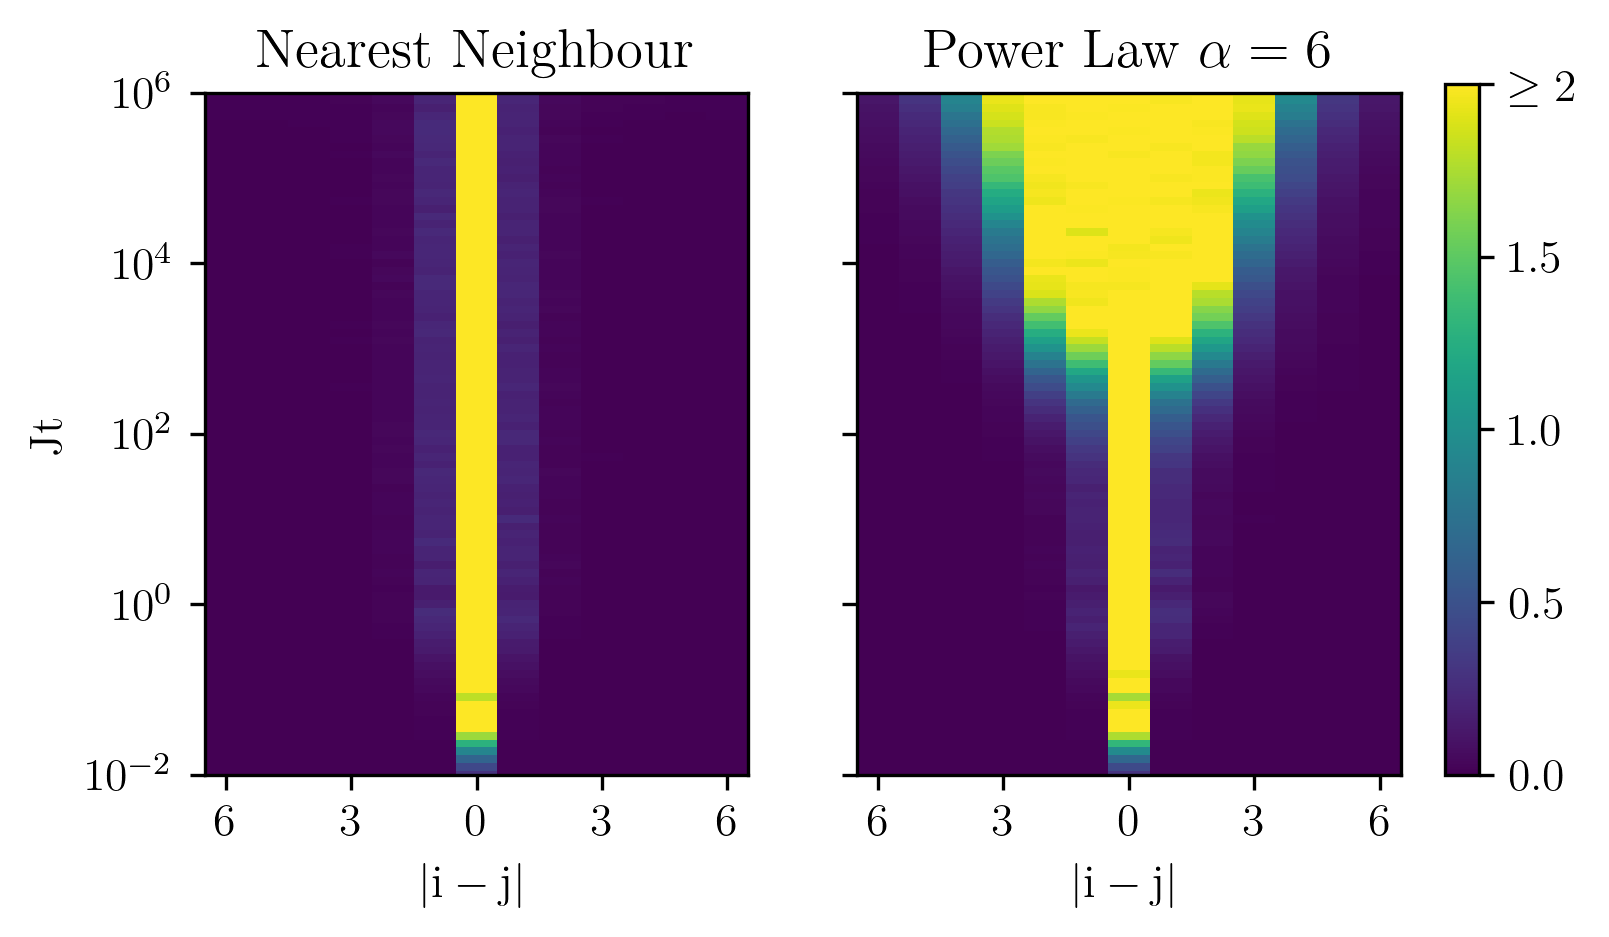

In [20]:
res_safe_AL = np.clip(res_nn[0],1e-14,2)
res_safe_AL_pl = np.clip(res[0],1e-14,2)
thresholds = [0.1,0.33,0.66,1,1.5,2]

fit_params = []
fit_errs = []
tvals = []
masks = []
# for (i,th) in enumerate(thresholds):
#     tvals.append(T_transgression(T,res_safe,th))
#     masks.append(np.isfinite(tvals[i])) 
#     popt, pcov = curve_fit(model,rvals[masks[i]],tvals[i][masks[i]])
#     fit_params.append(popt)
#     fit_errs.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)

pcm = axs[0].pcolormesh(range(0,N),T,res_safe_AL,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
# for (i,th) in enumerate(thresholds):
#     #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
#     ax1.plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
#     ax1.plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
#     ax1.scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 2)
# ax1.scatter(np.arange(0,8,1),tcut_zz,marker="o",color="red",s=2)
# ax1.scatter(np.arange(8+3,N,1),np.flip(tcut_zz),marker="o",color="red",s=2)
axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,3,N//2,9,N-1])
axs[0].set_xticklabels([6,3,0,3,6])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("Nearest Neighbour")




pcm2 = axs[1].pcolormesh(range(0,N),T,res_safe_AL_pl,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title(r"Power Law $\alpha=6$")



plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])

#plt.savefig(figurepath/"ALvsAL_pl.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Offcenter

In [34]:
rvals_nc = np.array([abs(pos-2) for pos in range(0,N)])

In [35]:
rvals_nc

array([ 2,  1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

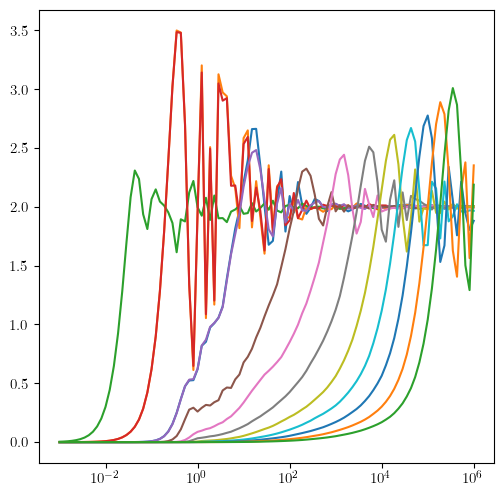

In [69]:
res1 = disorder_mean(data[-1],200)
plt.semilogx(T,res1[:,:])

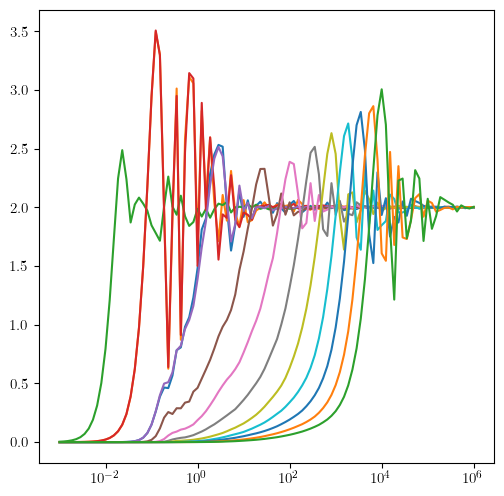

In [64]:
res2 = disorder_mean(data[-1][:,:,331:],170)
plt.semilogx(T,res2)

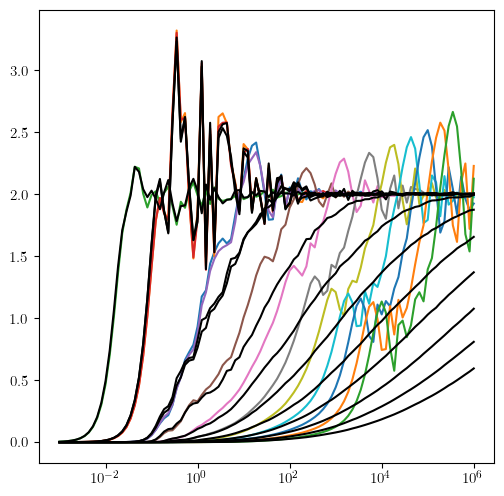

In [67]:
plt.semilogx(T,res[-1])
plt.semilogx(T,res_nn[-1],c="black")

In [70]:
res_corr = disorder_mean(data[-1],200)
res_corr_nn = disorder_mean(data_nn[-1],200)

[ 3  4  5  6  7  8  9 10]
[ 3  4  5  6  7  8  9 10]
[3 4 5 6 7]
[array([ 0.73243134, -1.66139677]), array([ 0.76180274, -1.20491344]), array([ 0.89491682, -1.32619948])] [array([ 2.76421859, -2.71877634]), array([ 2.52961503, -2.03619667]), array([ 2.42641247, -1.6630589 ])]


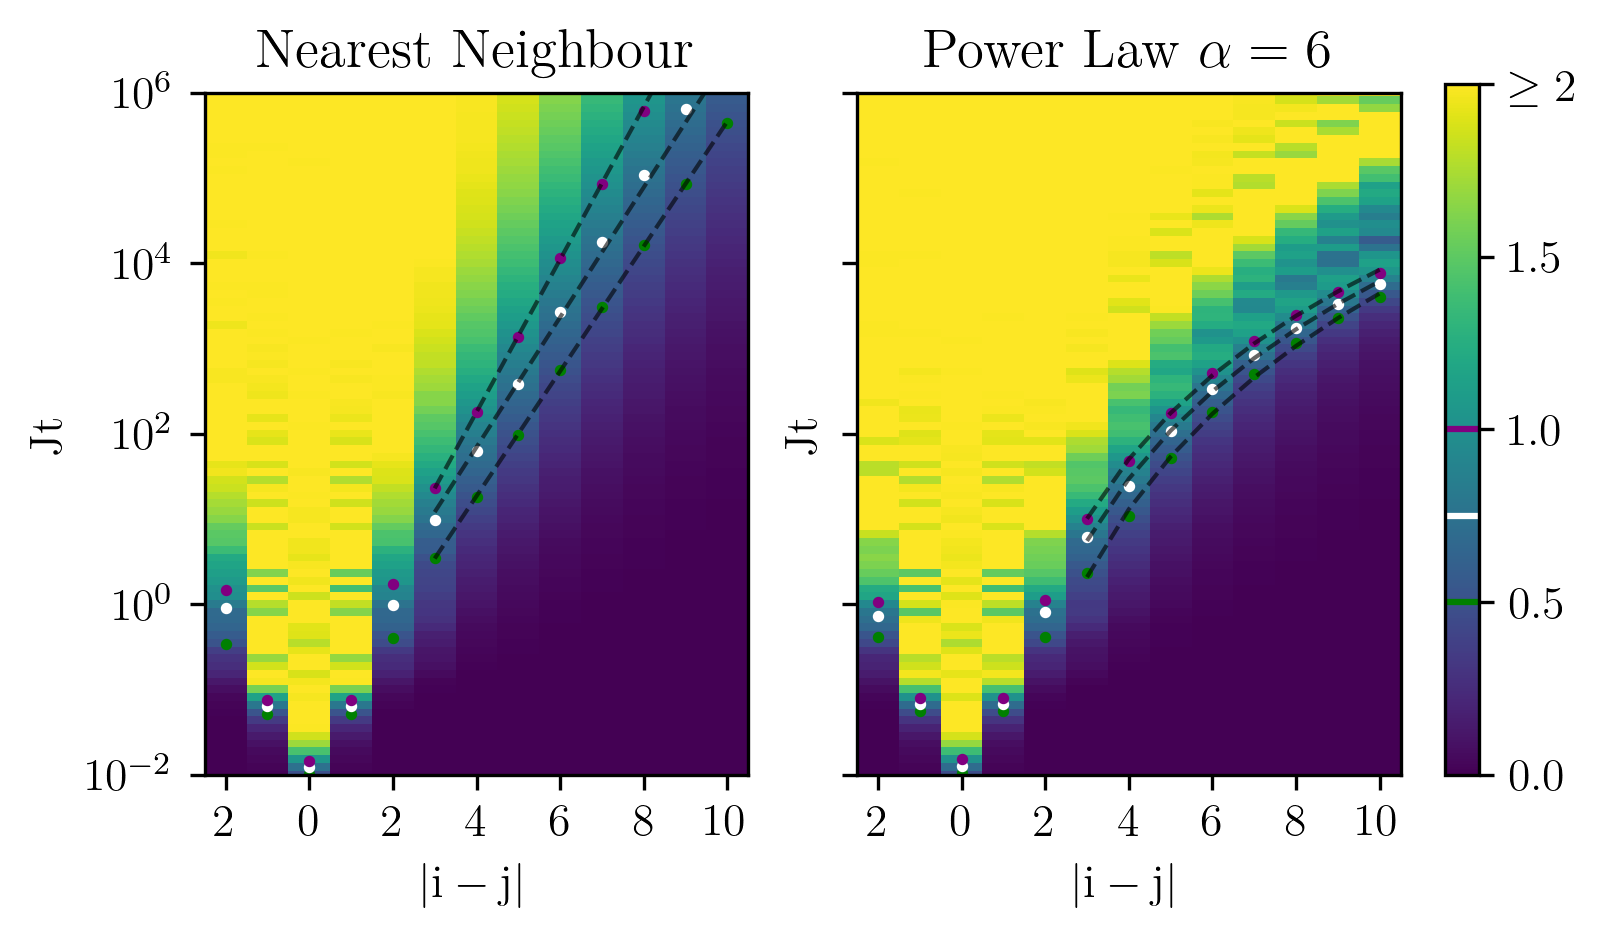

In [74]:
thresholds = [0.5,0.75,1.0]

fit_params = []
fit_errs = []
tvals = []
masks = []
fit_params_pl = []
fit_errs_pl = []
tvals_pl = []
masks_pl = []

ts = np.zeros((3,500,13))
ts_pl = np.zeros((3,500,13))

for (i,th) in enumerate(thresholds):
    #for s in range(6000):
    #    ts[i,s,:]=T_transgression(T,data_nn[-1][:,:,s],th)
    #tvals.append(np.mean(ts,axis=1))
    tvals.append(T_transgression(T,res_nn[-1],th))
    masks.append(np.isfinite(tvals[i]))
    masks[i][0:5] = False
    if i == 2:
        masks[i][10:] = False
    print(rvals_nc[masks[i]])
    popt, pcov = curve_fit(model1,rvals_nc[masks[i]],np.log10(tvals[i][masks[i]]))
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))



    #for s in range(6000):
    #    ts_pl[i,s,:]=T_transgression(T,data[1][:,:,s],th)
    #tvals_pl.append(np.mean(ts_pl,axis=1))
    tvals_pl.append(T_transgression(T,res[-1],th))
    masks_pl.append(np.isfinite(tvals_pl[i]))
    masks_pl[i][0:5] = False
    popt, pcov = curve_fit(model3,rvals_nc[masks_pl[i]],np.log10(tvals_pl[i][masks_pl[i]]))
    fit_params_pl.append(popt)
    fit_errs_pl.append(np.sqrt(np.diag(pcov)))

print(fit_params,fit_params_pl)

mcolors2 = ["green","white","purple"]*2


fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)


pcm = axs[0].pcolormesh(range(0,N),T,res_nn[-1],cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[0].plot(np.arange(0,N,1)[5:],10**model1(rvals_nc[5:],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[0].plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[0].plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[0].scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 3)

axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,2,4,6,8,10,12])
axs[0].set_xticklabels([2,0,2,4,6,8,10])
axs[0].set_yscale("log")
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("Nearest Neighbour")
axs[0].set_ylabel("Jt")



pcm2 = axs[1].pcolormesh(range(0,N),T,res[-1],cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[1].plot(np.arange(0,N,1)[5:],10**model3(rvals_nc[5:],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[1].plot(np.arange(0,N//2,1),tvals_pl[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[1].plot(np.arange(N//2+1,N,1),tvals_pl[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[1].scatter(np.arange(0,N,1),tvals_pl[i], marker= "o", c = mcolors2[i], s = 3)

axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,2,4,6,8,10,12])
axs[1].set_xticklabels([2,0,2,4,6,8,10])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title(r"Power Law $\alpha=6$")
axs[1].set_ylabel("Jt")


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])

plt.savefig(figurepath/"MBL_plvsMBL_nn_OBC.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

In [ ]:
[array([ 0.73243134, -1.66139677]), array([ 0.76180274, -1.20491344]), array([ 0.89491682, -1.32619948])] [array([ 2.76421859, -2.71877634]), array([ 2.52961503, -2.03619667]), array([ 2.42641247, -1.6630589 ])]


In [ ]:
def model1(x,a,b):
    return a*x+b
def model2(x,a,b,c):
    return a*x**b+c
def model3(x,a,b):
    return a*np.log(x)+b
def model4(x,a,b,c):
    return a*np.log(x)**b+c

In [219]:
i = 0

In [220]:
np.sqrt(np.abs((tvals_pl[i][5:]-model1(rvals_nc[5:],*fit_params_pl[i]))**2).sum())

6836.748081589336

In [221]:
np.sqrt(np.abs((tvals_pl[i][5:]-model3(rvals_nc[5:],*fit_params_pl[i])**2)).sum())

109.60828082654508

In [222]:
np.sqrt(np.abs((tvals[i][5:]-model1(rvals_nc[5:],*fit_params[i])**2)).sum())

1422.3179578565516

In [223]:
np.sqrt(np.abs((tvals[i][5:]-model3(rvals_nc[5:],*fit_params[i])**2)).sum())

1424.1461562089037

In [179]:
fit_errs

[array([0.15237268, 0.28080528]),
 array([0.18129228, 0.33410076]),
 array([0.19000948, 0.35016555])]

In [180]:
fit_errs_pl

[array([0.13485427, 0.24852087]),
 array([0.13955862, 0.25719043]),
 array([0.07478748, 0.13782471])]

In [ ]:
3622.315892097687   73.63191374293754

In [ ]:
22778.78638780991  183.6755129662561

In [ ]:
79483.12825176732  352.96242781338884

In [ ]:
93.73695762065572 93.73779435213287

In [ ]:
293.12409261239077 293.12447799479276

In [ ]:
1098.1696455615522 1098.169748968258